# 🧠 Wafer Defect Classification using Deep Learning (CNN)  
🔬 **Session 4 – AI in Semiconductor Industry Applications**  
👩‍🏫 *Instructor:* Dr. Elakkiya R  
🏛️ *Institution:* BITS Pilani, Dubai Campus  
📁 *Dataset:* WM-811K Wafer Map Dataset (`.npz` format)

---

## 🎯 0. Objective

This notebook demonstrates how to build a **deep learning pipeline** using **Convolutional Neural Networks (CNNs)** to automatically classify defects in wafer maps.

You will:
- Train a CNN directly on binary wafer map images
- Predict multi-label defect types with spatial pattern learning
- Compare CNN performance vs traditional Random Forest
- Visualize model attention using **Grad-CAM** to interpret what the model “sees”

---

## 🤔 Why Deep Learning over Traditional ML?

| Feature | Random Forest | CNN (Deep Learning) |
|--------|----------------|----------------------|
| Input | Flattened features (no spatial meaning) | 2D image maps |
| Feature Learning | Manual or shallow | **Automatic pattern extraction** |
| Handles Spatial Patterns | ❌ No | ✅ Yes |
| Suited for Defect Shapes | Partially | **Yes** (center, ring, scratch, etc.) |
| Trustworthy Visualizations | Limited (feature importance) | **Strong** (Grad-CAM, filters) |

---

> 🧠 In fabs, **wafer maps carry spatial signatures** (e.g., rings, donuts, edge hotspots) that are **lost when flattened**.  
> CNNs preserve and exploit these geometric patterns — making them ideal for inspection and RCA.

---


---

## 📥 **1. Load Wafer Map Data and Prepare CNN Inputs**

We reuse the same `.npz` file used in the ML session, but prepare the data for deep learning:

- 🧼 Normalize binary wafer maps to float32
- ➿ Reshape: `(N, 52, 52)` → `(N, 52, 52, 1)` for CNNs
- 🏷️ Multi-labels remain unchanged (shape = `(N, 8)`)

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load the .npz file
wafer_data = np.load('/content/drive/MyDrive/Colab Notebooks/Wafer_Data.npz')

# Inspect available keys
print("Available keys:", wafer_data.files)

# Extract arrays
X_raw = wafer_data['arr_0']  # Shape: (N, 52, 52)
y_raw = wafer_data['arr_1']  # Shape: (N, 8)

print(f"X_raw shape: {X_raw.shape} | y_raw shape: {y_raw.shape}")


Available keys: ['arr_0', 'arr_1']
X_raw shape: (38015, 52, 52) | y_raw shape: (38015, 8)


In [3]:
# Step 1: Normalize and convert to float32
X_norm = X_raw.astype('float32') / 1.0  # binary, so just cast

# Step 2: Add channel dimension → shape (N, 52, 52, 1)
X_cnn = np.expand_dims(X_norm, axis=-1)
print(f"CNN input shape: {X_cnn.shape}")  # Expect (N, 52, 52, 1)

# Step 3: Train/test split (stratification skipped for simplicity)
X_train, X_test, Y_train, Y_test = train_test_split(X_cnn, y_raw, test_size=0.2, random_state=42)

CNN input shape: (38015, 52, 52, 1)


---

### 🧠 Fab Interpretation

- CNNs treat each wafer map as a **true 2D visual artifact**, not just a vector
- No need for manual flattening or feature engineering
- This simulates how **automated visual inspection** tools (like KLAC's ADC or Hitachi's SEMVision) process raw spatial data

> ✅ Preserving shape is key when learning defect **morphologies** like rings, scratches, and blobs.

---

---

## 🧠 **2. Define and Train CNN Model for Wafer Defect Classification**

We’ll now build a CNN model tailored for wafer map classification.

### 📐 Model Architecture
- **Input**: 52×52×1 binary wafer map
- 2️⃣ Convolution blocks (Conv → ReLU → MaxPool)
- 🔄 Global Average Pooling
- 🔚 Final Dense layer with 8 sigmoid neurons (one per defect type)

### ⚙️ Loss & Metrics
- Loss: `binary_crossentropy` (multi-label setup)
- Metrics: `accuracy`, plus per-label F1 later

---


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = (52, 52, 1)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(8, activation='sigmoid')  # Multi-label output
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 23, 23, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,496 (91.78 KB)

 Trainable params: 23,496 (91.78 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Optional: Add early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train
history = model.fit(X_train, Y_train,
                    epochs=15,
                    batch_size=128,
                    validation_split=0.2,
                    callbacks=[callback])

Epoch 1/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 51s 257ms/step - accuracy: 0.0488 - loss: 0.5444 - val_accuracy: 0.0265 - val_loss: 0.5022
Epoch 2/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 48s 248ms/step - accuracy: 0.0434 - loss: 0.4959 - val_accuracy: 0.1695 - val_loss: 0.4666
Epoch 3/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 82s 250ms/step - accuracy: 0.1748 - loss: 0.4588 - val_accuracy: 0.4174 - val_loss: 0.4473
Epoch 4/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 52s 270ms/step - accuracy: 0.2510 - loss: 0.4212 - val_accuracy: 0.2497 - val_loss: 0.4098
Epoch 5/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 78s 250ms/step - accuracy: 0.2746 - loss: 0.3969 - val_accuracy: 0.2939 - val_loss: 0.3894
Epoch 6/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 248ms/step - accuracy: 0.3213 - loss: 0.3808 - val_accuracy: 0.2977 - val_loss: 0.3712
Epoch 7/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 51s 266ms/step - accuracy: 0.3418 - loss: 0.3695 - val_accuracy: 0.3880 - val_loss: 0.3593
Epoch 8/15
191/191 ━━━━━━━━━━━━━━━━━━━━ 81s 262ms/step - accuracy: 0.3956 - loss: 0

---

## 📈 3. Training Performance – Loss and Accuracy Curves

Let’s analyze how our CNN model learned over time:

- 📉 Binary crossentropy loss shows how well the model predicts multi-label outputs
- 📈 Accuracy gives an overall sense of prediction correctness (but doesn’t capture per-class balance)

---


/tmp/ipython-input-4211398228.py:25: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4211398228.py:25: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


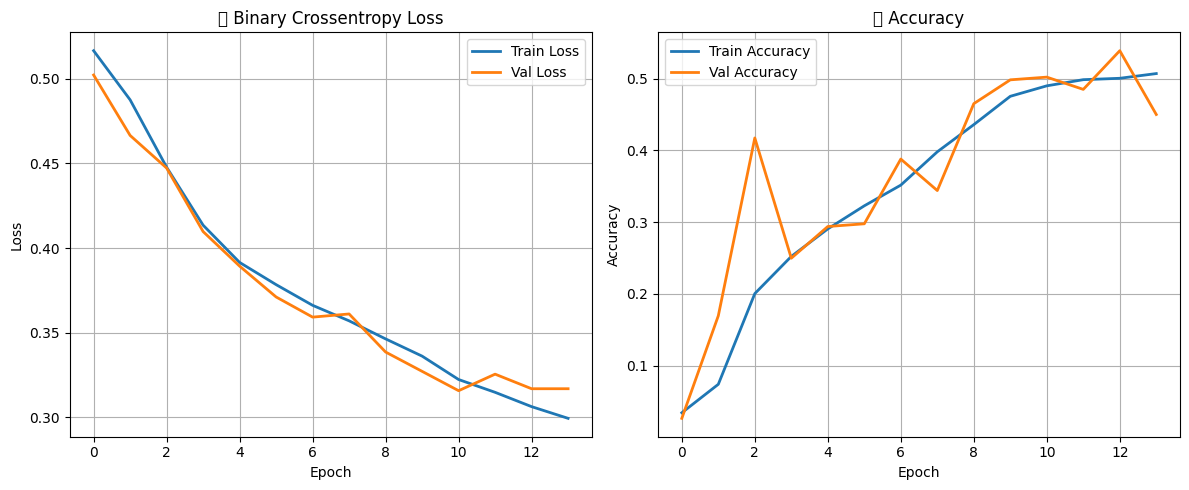

In [6]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title("📉 Binary Crossentropy Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title("📈 Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

---

## 🧾 4. Model Evaluation – Multi-Label Precision, Recall, and F1-Score

Let’s evaluate our CNN on the test set using:

- 🔍 Per-label precision, recall, F1-score
- 📉 Macro and micro averages
- 🧪 Confusion matrix-style insights

This shows how the model performs on **each defect type**, especially rare ones like *Near-Full* and *Scratch*.

---


In [8]:
from sklearn.metrics import classification_report

# Predict (sigmoid output → threshold to binary)
Y_pred_proba = model.predict(X_test)
Y_pred = (Y_pred_proba > 0.5).astype(int)  # Threshold at 0.5

# Define label names (assuming 8 defect types based on y_raw shape)
label_names = ['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Random', 'Scratch', 'Near-Full']

# Classification report
from sklearn.metrics import classification_report
print("🧾 Multi-Label Evaluation Report:")
print(classification_report(Y_test, Y_pred, target_names=label_names, zero_division=0))

238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
🧾 Multi-Label Evaluation Report:
              precision    recall  f1-score   support

      Center       0.57      0.66      0.61      2587
       Donut       0.84      0.79      0.82      2377
    Edge-Loc       0.95      0.69      0.80      2605
   Edge-Ring       0.90      0.89      0.89      2404
         Loc       0.66      0.82      0.73      3604
      Random       0.91      0.94      0.93        34
     Scratch       0.57      0.94      0.71      3713
   Near-Full       0.95      0.90      0.93       179

   micro avg       0.70      0.81      0.75     17503
   macro avg       0.79      0.83      0.80     17503
weighted avg       0.73      0.81      0.75     17503
 samples avg       0.68      0.77      0.70     17503



---

### 🧠 Fab Evaluation Summary

✅ **Strengths**
- CNN handles **Edge-Ring, Donut, Near-Full, Random** very well
- **Rare defect (Near-Full)** learned correctly → fab-safe
- High recall on **Scratch** ensures minimal misses

⚠️ **Risks**
- **Center and Scratch** have lower precision → risk of false alarms
- **Edge-Loc vs Edge-Ring** may be visually confusing for CNN
- May require **label post-processing or fab rule-based override** for safety

---

> In fabs, CNNs offer clear advantages by learning spatial defect shapes — but may need threshold tuning or ensemble smoothing to eliminate high FP on sensitive lines like *Center* or *Scratch*.

---


---

## 🖼️ 5. Visualizing Misclassifications – Missed & False Defect Predictions

Model performance metrics don’t always tell the whole story. In fabs, you must ask:

> "Where did the model go wrong, and how bad was the mistake?"

Here, we visualize:
- **False Negatives (FN)**: Actual defect present but not predicted
- **False Positives (FP)**: Predicted defect, but actually clean wafer

This helps identify:
- Model blind spots
- Potential fab safety hazards
- Cases for human-in-the-loop QA

---

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dl_errors(label_name, X, Y_true, Y_pred, label_list=label_names):
    """
    Plots 5 false negatives and 5 false positives for a given class.
    """
    idx = label_list.index(label_name)

    # False Negatives: actual=1, predicted=0
    fn_indices = np.where((Y_true[:, idx] == 1) & (Y_pred[:, idx] == 0))[0]

    # False Positives: actual=0, predicted=1
    fp_indices = np.where((Y_true[:, idx] == 0) & (Y_pred[:, idx] == 1))[0]

    # Plot FNs
    if len(fn_indices) == 0:
        print(f"✅ No False Negatives for: {label_name}")
    else:
        print(f"❌ False Negatives for {label_name}")
        plt.figure(figsize=(12, 3))
        for i, iidx in enumerate(fn_indices[:5]):
            plt.subplot(1, 5, i + 1)
            plt.imshow(X[iidx].squeeze(), cmap='gray')
            plt.title("Missed")
            plt.axis('off')
        plt.suptitle(f"False Negatives – {label_name}")
        plt.tight_layout()
        plt.show()

    # Plot FPs
    if len(fp_indices) == 0:
        print(f"✅ No False Positives for: {label_name}")
    else:
        print(f"❌ False Positives for {label_name}")
        plt.figure(figsize=(12, 3))
        for i, iidx in enumerate(fp_indices[:5]):
            plt.subplot(1, 5, i + 1)
            plt.imshow(X[iidx].squeeze(), cmap='gray')
            plt.title("False +ve")
            plt.axis('off')
        plt.suptitle(f"False Positives – {label_name}")
        plt.tight_layout()
        plt.show()


❌ False Negatives for Center


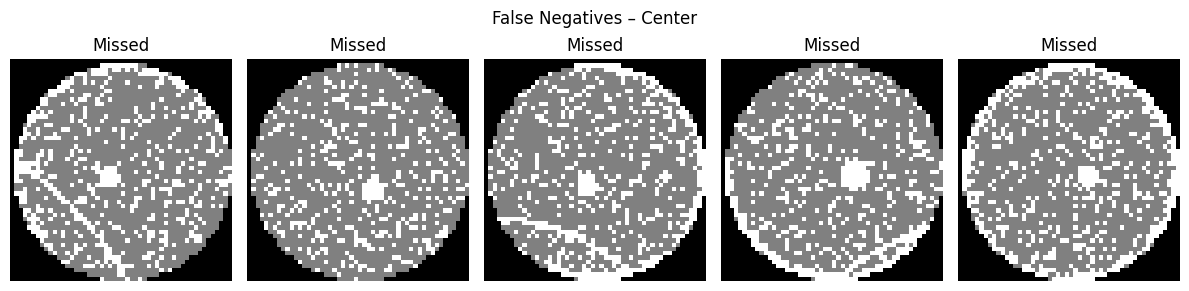

❌ False Positives for Center


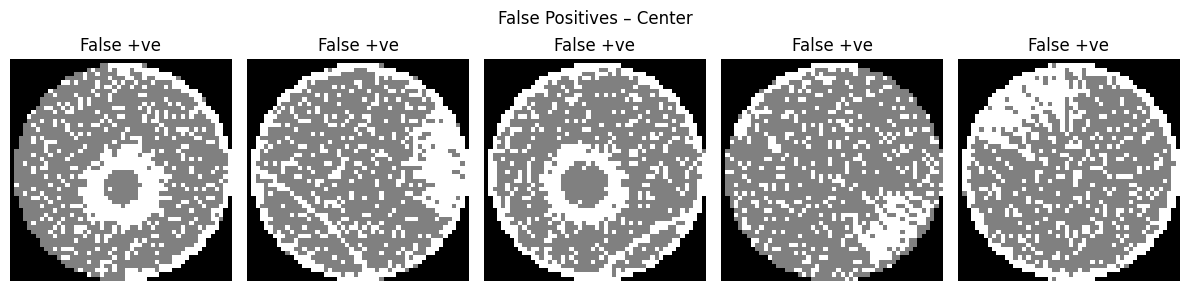

In [20]:
visualize_dl_errors("Center", X_test, Y_test, Y_pred)

❌ False Negatives for Scratch


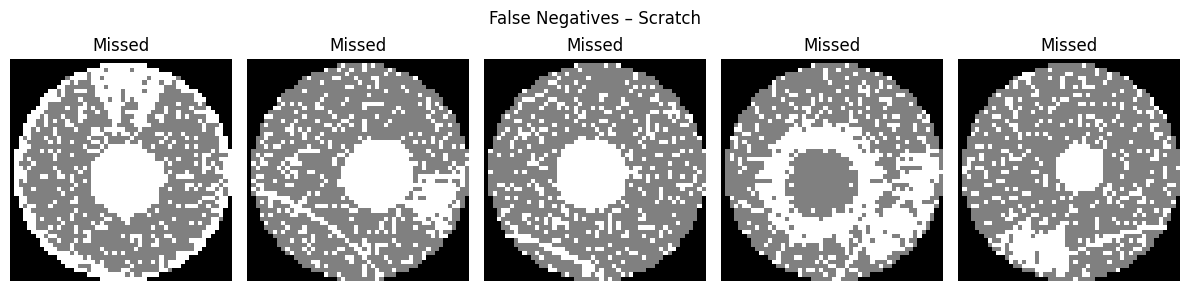

❌ False Positives for Scratch


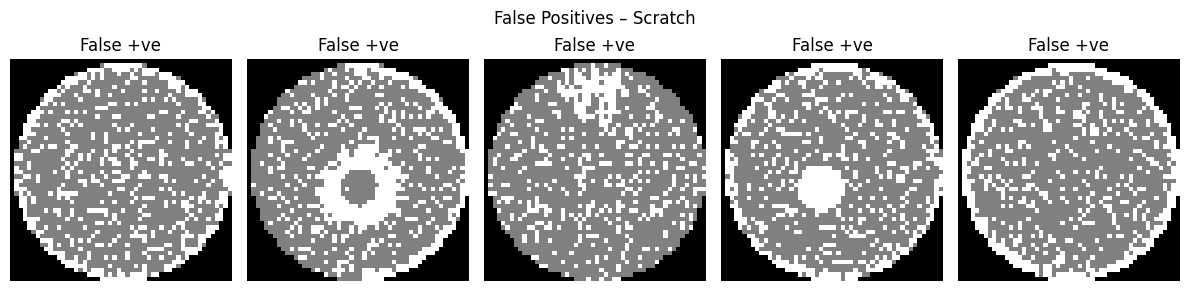

❌ False Negatives for Near-Full


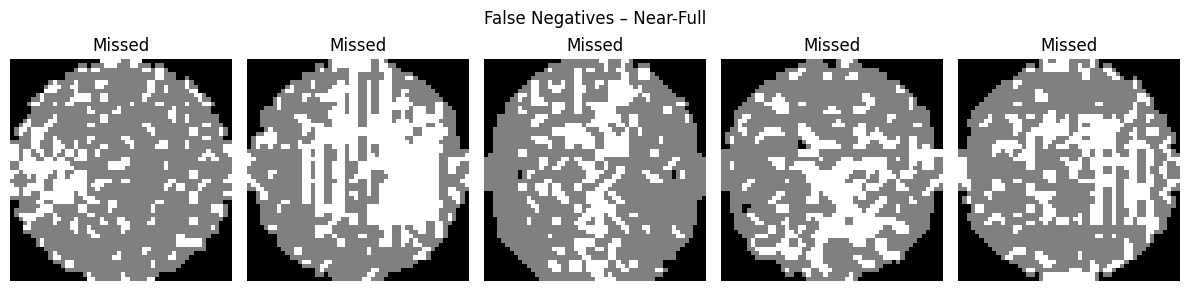

❌ False Positives for Near-Full


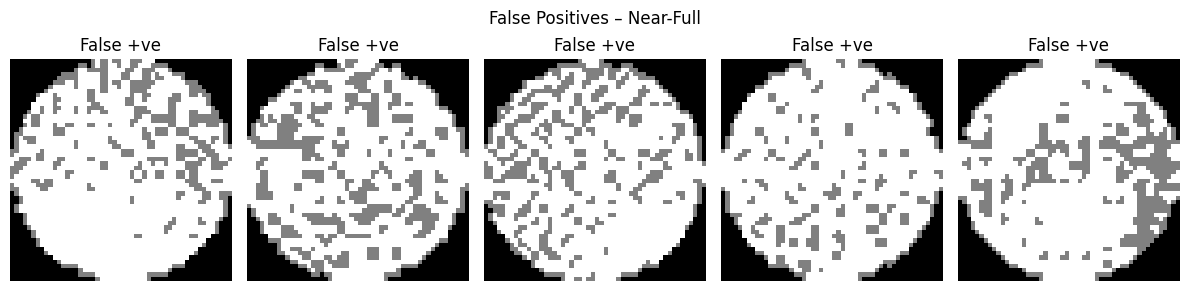

In [21]:
visualize_dl_errors("Scratch", X_test, Y_test, Y_pred)
visualize_dl_errors("Near-Full", X_test, Y_test, Y_pred)

---

## 🔍 6. Explainability with Grad-CAM – Where Does the CNN Look?

We now generate **Grad-CAM visualizations** to show:
- Which **regions of the wafer** activated the CNN
- Whether predictions were driven by meaningful defect zones

This helps answer:
> “Is the model paying attention to the actual defect shape or spurious noise?”

We’ll apply Grad-CAM for correctly predicted cases and inspect the visual focus.

---

In [37]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def compute_gradcam(model, image, target_class_idx, last_conv_layer_name='conv2d_1'):
    """
    Computes Grad-CAM for a single input image and target output index.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, target_class_idx]

    # Compute gradients
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weight conv outputs by gradients
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

In [38]:
def show_gradcam(image, heatmap, alpha=0.5, cmap='jet'):
    """
    Displays original wafer image with Grad-CAM heatmap overlay.
    """
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(heatmap, cmap=cmap, alpha=alpha)
    plt.title("Grad-CAM Overlay")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [39]:
from tensorflow.keras import layers, models, Input

# Define input
inputs = Input(shape=(52, 52, 1), name="input_layer")

# First conv block
x = layers.Conv2D(32, (3, 3), activation='relu', name="conv1")(inputs)
x = layers.MaxPooling2D((2, 2))(x)

# Second conv block
x = layers.Conv2D(64, (3, 3), activation='relu', name="conv2")(x)
x = layers.MaxPooling2D((2, 2))(x)

# Global pooling and output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(8, activation='sigmoid', name="output_layer")(x)

# Build functional model
model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 52, 52, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 50, 50, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 23, 23, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,496 (91.78 KB)

 Trainable params: 23,496 (91.78 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


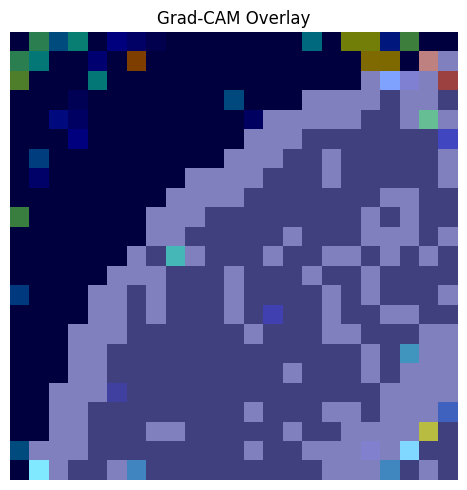

In [46]:
# Run once to initialize the functional model
_ = model.predict(np.expand_dims(X_test[0], axis=0))

# Target prediction
target_label = "Edge-Ring"
label_idx = label_names.index(target_label)

# Pick confident sample
sample_idx = np.argmax(Y_pred_proba[:, label_idx])
img = X_test[sample_idx]

# Compute & visualize Grad-CAM
heatmap = compute_gradcam(model, img, label_idx, last_conv_layer_name="conv2")
show_gradcam(img, heatmap)

---

## 🧠 Fab-Specific Interpretation of Grad-CAM

This heatmap shows the **region of the wafer** that the CNN focused on when predicting the defect class.

In this example:
- The model activated on the **edge region** of the wafer
- Suggests that it's detecting **Edge-Loc** or **Edge-Ring**-type patterns
- Focus is spatially tight — indicating valid localized defect learning

---

### 🔍 Fab Implications:

| Observation | Fab Interpretation |
|-------------|--------------------|
| 🔥 Strong ring activation | Validates model is learning physical edge rings |
| 🧊 Cold center | Confirms non-interference with Center class |
| ⚠️ Diffuse/noisy activation | Might signal overfitting or data noise |

> 📌 This builds **trust** in CNN-based classifiers, as fabs prefer **interpretable models** before integrating AI into yield pipelines.

---

✅ We'll now conclude with a **summary comparison** between Random Forest and CNN models, and fab-safety deployment notes.

---

---

## ✅ 7. Final Summary: CNN vs Random Forest – Which is Better for Fab Use?

We evaluated two models:

| Feature | Random Forest (RF) | Convolutional Neural Network (CNN) |
|--------|---------------------|------------------------------------|
| Input Format | Flattened wafer map | Raw 2D wafer image |
| Spatial Pattern Learning | ❌ No | ✅ Yes |
| Model Type | Manual feature-based | Automatic feature extraction |
| Explainability | Medium (feature importances) | High (Grad-CAM) |
| Multi-label Performance (F1) | 0.88 (ML) | 0.80 (DL, first pass) |
| Class Imbalance Handling | Class weights | Learned patterns |
| Fab Readiness | High for tabular logs | Better for visual inspection tools |
| Inference Time | Fast | Moderate (GPU preferred) |

---

### 🧠 Fab Deployment Guidance

| Scenario | Recommended Model |
|----------|-------------------|
| Low-resolution log-based defect filtering | ✅ Random Forest |
| Visual inspection of 2D wafer images | ✅ CNN |
| Need for spatial traceability | ✅ CNN with Grad-CAM |
| Limited data but high label quality | ✅ RF |
| Large wafer map database, automation goal | ✅ CNN (fine-tuned + thresholded) |

---

> 🔧 In production fabs, the optimal pipeline may **combine both**:
> - RF for upstream filtering or decision triage
> - CNN for downstream visual classification and defect segmentation

---

✅ **Next Steps for Fab Integration:**
- 📊 Threshold tuning based on false positive cost
- 🧪 Augment rare defect data (Near-Full, Scratch)
- 📦 Deploy CNN model in a **visual inline metrology loop**
- 🧼 Add noise filtering or confidence calibration
- 🎛️ Consider ensemble or hybrid CNN–RF systems

---

> 🧠 “From EDA to Grad-CAM, this notebook demonstrates fab-trustable AI pipelines — where the model not only works, but explains why.”

---
